In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_hep.csv', index_col='CASEID')
data = data.drop(['Unnamed: 0'], axis=1)

In [3]:
data.columns

Index(['PRNCPTX', 'CPT', 'CONCPT1', 'OTHERCPT1', 'OPERYR', 'SEX', 'AGE',
       'HEIGHT', 'WEIGHT', 'RACE_NEW', 'ETHNICITY_HISPANIC', 'TRANST',
       'WNDCLAS', 'ASACLAS', 'DIABETES', 'SMOKE', 'DYSPNEA', 'FNSTATUS2',
       'VENTILAT', 'HXCOPD', 'ASCITES', 'HXCHF', 'HYPERMED', 'RENAFAIL',
       'DIALYSIS', 'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS',
       'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRBILI', 'PRALKPH', 'PRWBC',
       'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR', 'SEPSHOCKPATOS', 'SSSIPATOS',
       'DSSIPATOS', 'OSSIPATOS', 'PNAPATOS', 'VENTPATOS', 'UTIPATOS',
       'SEPSISPATOS', 'SEPSHOCKPATOS.1', 'OPTIME', 'OTHBLEED.1', 'HEP_NEOADJ',
       'HEP_RECON', 'HEP_CON_OP_ABLATION', 'HEP_LIVERTEXT', 'HEP_PRINGLE',
       'HEP_CON_ABLATION_140101', 'HEP_BILIARYSTENT', 'HEP_LAPTHOR',
       'HEP_APPROACH', 'HEP_DRAINS', 'HEP_VIRAL', 'HEP_BILELEAKAGE',
       'HEP_CON_PARTRES', 'BMI', 'CHEMO', 'EMBO', 'INFU', 'ABLA'],
      dtype='object')

In [4]:
y_names=['HEP_BILELEAKAGE']

In [5]:
cat = ['HEP_CON_OP_ABLATION',
 'HEP_PRINGLE',
 'HEP_APPROACH',
 'HEP_CON_ABLATION_140101',
 'HEP_VIRAL',
 'HEP_RECON',
 'HEP_LIVERTEXT',
 'HEP_NEOADJ',
 'HEP_BILIARYSTENT',
 'HEP_CON_PARTRES',
 'HEP_DRAINS',
 'CHEMO',
 'EMBO',
 'INFU',
 'ABLA'
            ]
cont = []
features = cat + cont + y_names
data = data[features]

In [6]:
columns = {'Concurrent ablation':'HEP_CON_OP_ABLATION',
 'Pringle maneuver':'HEP_PRINGLE',
 'Approach':'HEP_APPROACH',
 'Type of ablation':'HEP_CON_ABLATION_140101',
 'Viral hepatitis':'HEP_VIRAL',
 'Biliary reconstruction':'HEP_RECON',
 'Liver texture':'HEP_LIVERTEXT',
 'Neoadjuvant therapy':'HEP_NEOADJ',
 'Biliary stent':'HEP_BILIARYSTENT',
  '# of concurrent resections':'HEP_CON_PARTRES',
 'Use of drain':'HEP_DRAINS',
 'Neoadjuvant chemotherapy':'CHEMO',
 'Neoadjuvant chemo-embolization':'EMBO',
 'Neoadjuvant chemo-infusion':'INFU',
 'Neoadjuvant ablation':'ABLA',}
col = {value : key for key, value in columns.items()}
data.rename(columns=col, errors='raise', inplace=True)

In [7]:
data.head()

,Concurrent ablation,Pringle maneuver,Approach,Type of ablation,Viral hepatitis,Biliary reconstruction,Liver texture,Neoadjuvant therapy,Biliary stent,# of concurrent resections,Use of drain,Neoadjuvant chemotherapy,Neoadjuvant chemo-embolization,Neoadjuvant chemo-infusion,Neoadjuvant ablation,HEP_BILELEAKAGE
CASEID,,,,,,,,,,,,,,,,
7646,0,0,2,5,3,0,5,0,0,0,2,0,0,0,0,0
7653,0,1,0,5,3,0,2,0,0,1,0,0,0,0,0,0
7665,2,1,2,4,3,0,5,0,0,3,2,0,0,0,0,1
7705,0,1,2,5,3,0,5,0,0,1,2,0,0,0,0,0
7706,0,1,2,5,2,0,0,0,0,1,0,0,0,0,0,0


In [9]:
y = data['HEP_BILELEAKAGE']
X = data.drop(['HEP_BILELEAKAGE'], axis=1)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [10]:
input_shape = [X.shape[1]]
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=1e-6,
    restore_best_weights=True,)
model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])



Instructions for updating:
Colocations handled automatically by placer.
Train on 20322 samples, validate on 5081 samples
Epoch 1/200
19968/20322 [============================>.] - ETA: 0s - loss: 0.4501 - Sensitivity: 0.1647 - tn: 16440.0000 - auc: 0.5090 - prc: 0.0422

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


20322/20322 [==============================] - 1s 67us/sample - loss: 0.4462 - Sensitivity: 0.1638 - tn: 16774.0000 - auc: 0.5093 - prc: 0.0420 - val_loss: 0.4815 - val_Sensitivity: 0.0406 - val_tn: 4855.0000 - val_auc: 0.6677 - val_prc: 0.0890
Epoch 2/200
20322/20322 [==============================] - 0s 17us/sample - loss: 0.2363 - Sensitivity: 0.0377 - tn: 19207.0000 - auc: 0.5351 - prc: 0.0476 - val_loss: 0.3024 - val_Sensitivity: 0.0051 - val_tn: 4883.0000 - val_auc: 0.6343 - val_prc: 0.0810
Epoch 3/200
20322/20322 [==============================] - 0s 17us/sample - loss: 0.2247 - Sensitivity: 0.0494 - tn: 19298.0000 - auc: 0.5548 - prc: 0.0560 - val_loss: 0.2403 - val_Sensitivity: 0.0102 - val_tn: 4878.0000 - val_auc: 0.6354 - val_prc: 0.0873
Epoch 4/200
20322/20322 [==============================] - 0s 17us/sample - loss: 0.2145 - Sensitivity: 0.0533 - tn: 19319.0000 - auc: 0.5870 - prc: 0.0628 - val_loss: 0.2190 - val_Sensitivity: 0.0051 - val_tn: 4881.0000 - val_auc: 0.6318 - 

keras is no longer supported, please use tf.keras instead.


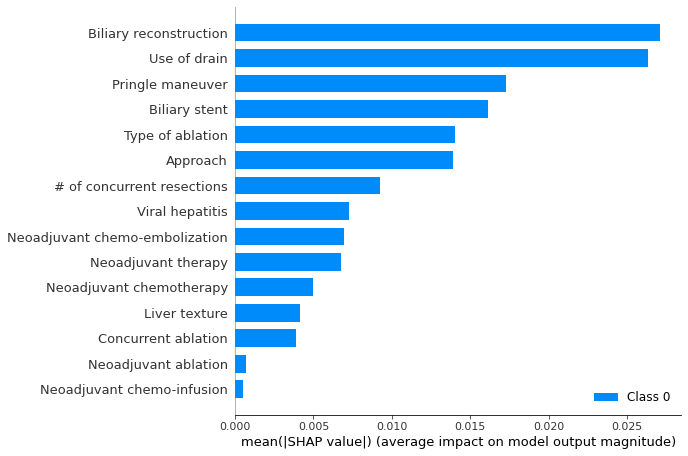

In [11]:
import shap
tf.config.list_physical_devices('GPU')
explainer = shap.DeepExplainer(model4, X_train.sample(n=5000))
shap_values = explainer.shap_values(X_valid.sample(n=5000).values)
shap.summary_plot(shap_values, X_valid.sample(n=5000))

In [12]:
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
5,Biliary reconstruction,0.027105
10,Use of drain,0.026326
1,Pringle maneuver,0.017309
8,Biliary stent,0.016111
3,Type of ablation,0.014046
2,Approach,0.013875
9,# of concurrent resections,0.009265
4,Viral hepatitis,0.007257
12,Neoadjuvant chemo-embolization,0.006943
7,Neoadjuvant therapy,0.006747


In [13]:
feature_importance.to_excel('shap_hep.xlsx')

mapping = {'PAN_JAUNDICE':'Jaundice', 'PAN_BILIARYSTENT':'Biliary stent', 'PAN_CHEMO':'Chemotherapy', 'PAN_RADIO':'Radiation therapy', 'PAN_INTRA_ANTIBIOTICS':'Antibiotic',  'PAN_DUCTSIZE':'Duct size', 'PAN_GLANDTEXT':'Gland texture', 'PAN_RECONSTRUCTION':'Reconstruction',  'PAN_DRAINS':'Drains', 'PAN_DRAINS_TYPE':'Drain location', 'PAN_DRAINSYS_TYPE':'Drain type', 'PAN_DRAINSYS_SUCTN':'Drain suction', 'PAN_RESECTION':'Vascular resection','PAN_AMYLASE_POD1':'Drain amylase (POD1)'}


In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [12]:
coef = lr.coef_
coef.shape
ors = np.exp(coef)
ors = ors.squeeze()

or_df = pd.DataFrame(ors, columns = X_train.columns)

In [14]:
or_df = pd.DataFrame(list(zip(X_train.columns, ors)),columns=['col_name','odds ratio'])

In [ ]:
or_df['diff'] = abs(1 - or_df['odds ratio'])
or_df.sort_values(by='diff', ascending=False).to_excel('ors_hep.xlsx')